## Detekcia falošných politických a ekonomických správ - ponechanie rozdelenia cieľového atribútu, vymazané stop slová

#### Ako prvé načítame všetký potrebné knižnice.

In [2]:
#načítanie potrebných knižníc
import pandas as pd
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import WordPunctTokenizer, word_tokenize
from bs4 import BeautifulSoup
import re
import nltk
import gensim
from gensim.models import Word2Vec
import os
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, Model, load_model
from keras.layers import Input, concatenate, Activation, Dense, Dropout, Flatten, LSTM, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score

from sklearn.model_selection import GridSearchCV, KFold
from keras.wrappers.scikit_learn import KerasClassifier
import collections

Using TensorFlow backend.


#### Načítame dátovu množinu, ktorú sme získali z aplikácie POSTMAN. Články máme uložené v dvoch súboroch.

In [3]:
#načítanie dátových množín
home=pd.read_csv("detekcia_Homenews2.csv")
home2=pd.read_csv("detekcia_Homenews.csv")

#### Spojíme predchádzajúce dve množiny do jedného súboru a potenciálne duplicitné hodnoty vymažeme na základe atribútu, ktorý uchováva url adresu článku.

In [4]:
#spojenie dvoch dátových množín a vymazanie potenciálnych duplikátov podľa url adresy článku
home_nove=home2.append(home, ignore_index=True, sort=False)
home_nove=home_nove.drop_duplicates(subset='url', keep="last")

#### Nižšie je vypísaná ukážka dátovej množiny, kde môžeme vidieť, že množina obsahuje atribúty ako name, url, body, perex. Atribút name nám hovorí o názve autora článku, url atribút hovorí  o url adrese odkazujúcej sa na článok, body je telo samotného článku, podľa ktorého sme správy detekovali, perex je úvodná, hrubo vytlačená časť článku tzv. uvedenie.

In [5]:
#ukážka dátovej množiny
home_nove.head()

,name,url,body,perex
1,magnificat.sk,http://www.magnificat.sk/cudna-ekumena-na-fest...,"\r\n \r\n„Katolícka moderna“, ako sa zdá, zav...",<p>&nbsp; &nbsp; &#8222;Katolícka moderna&#822...
2,magnificat.sk,http://www.magnificat.sk/nevsedna-vystava-v-br...,"\r\nMilí priatelia, Robert Richter prešiel vo ...","<p>Milí priatelia, Robert Richter prešiel vo s..."
3,magnificat.sk,http://www.magnificat.sk/ukrajinske-peklo/,Média vylíčila Berkut a další činitele jako fa...,<p>Média vylíčila Berkut a další činitele jako...
20,Petit Press,https://zriedkavechoroby.blog.sme.sk/c/522415/...,Rakovina pankreasu má najnižšiu mieru prežitia...,Rakovina pankreasu má najnižšiu mieru prežitia...
21,ta3.com,https://www.ta3.com/clanok/1170735/vnima-reali...,NaN,Stratifikácia nemocníc zostáva kompletne pripr...


#### Nižšie je zoznam všetkých autorov článkov s početnošťami článkov od jednotlivých autorov.

In [6]:
#výpis autorov a počet ich článkov
home_nove.name.value_counts()

TASR                         10368
slobodnyvysielac.sk           7070
Martina Max                   2356
redaktor maria miz            1824
sme.sk                        1424
ta3.com                       1155
redaktor maria dutkova        1140
aktuality.sk                  1066
redaktor jana frielichova     1058
redaktor janka papcunova       973
TASR - HSP                     813
hnonline.sk                    708
maria palastova                338
redaktor jaroslav              332
Redakcia                       310
zemavek.sk                     297
redaktor zuzana                279
redakto anton                  180
tomas zajaros                  158
redaktor lukas                 144
::prop                          82
Autor                           74
Petit Press                     69
admin                           61
redaktor ivana                  52
redaktor viliam varga           49
magnificat.sk                   44
HSP                             18
redaktor slavka     

#### Z dátovej množiny vymažeme zdroj blog.sme, pretože je pre náš výber článkov, ktoré sa zameriavajú na politiku a ekonomiku nerelevantný. Nižšie tiež nastavíme autorom jednotlivých článkov dôverihodnosť a to 0 - pravdivé články, 1 - nepravdivé. K zisťovaniu dôveryhodnosti daných článkov nám z časti pomohla stránka konšpirátori.sk, ale taktiež sme vykonali aj manuálne priradenie relevantnosti. Z každého zdroja, odkiaľ články pochádzali, sme si vybrali náhodne zopár článkov, ktoré sme celé prečítali a priradili následne všetkým článkom z daného zdroja relevantnosť.

In [7]:
#vymazanie zdroja blog.sme pretože je nerelevantny
home_nove=home_nove[home_nove.name != 'sme.sk']
home_nove=home_nove[home_nove.name != 'Petit Press'] 

#nastavenie cieľového atribútu 
home_nove["label"]=np.where(home_nove["name"].str.contains("ta3")|home_nove["name"].str.contains("aktuality")|home_nove["name"].str.contains("TASR")|home_nove["name"].str.contains("hnonline")|home_nove["name"].str.contains("Autor")|home_nove["name"].str.contains("maria dutkova")|home_nove["name"].str.contains("janka papcunova")
                        |home_nove["name"].str.contains("maria miz")|home_nove["name"].str.contains("Martina Max")|home_nove["name"].str.contains("tomas zajaros")|home_nove["name"].str.contains("jana frielichova")|home_nove["name"].str.contains("anton")|home_nove["name"].str.contains("maros kyjovsky"), 0,1)


#### Po vytvorení cieľového atribútu si vypíšeme pomer pravdivých a nepravdivých článkov nachádzajúcich sa v dátovej množine.

In [8]:
#pomer cieľového atribútu
home_nove.label.value_counts()

0    21892
1     9110
Name: label, dtype: int64

#### Vypíšeme si aj počet prázdnych hodnôt nachádzajúcich sa v jednotlivých atribútoch.

In [9]:
#počet prázdnych hodnôt
home_nove.isna().sum()

name        0
url         0
body     2307
perex      95
label       0
dtype: int64

#### Veľa článkov obsahuje prázdne hodnoty v atribúte body, a keďže o tieto články nechceme prísť atribútu body priradíme text z atribútu perex.

In [10]:
#veľa NA hodnôt mali pravdivé texty, čiže z perexu sme vzali text a priradili ho do body
home_nove["body"]=home_nove["body"].fillna(home_nove["perex"])

In [11]:
home_nove.isna().sum()

name      0
url       0
body     29
perex    95
label     0
dtype: int64

#### Ak článok obsahuje prázdne hodnoty pre jeden aj druhý atribút vymažeme ho. 

In [12]:
#vymazanie prázdnych hodnôt
home_nove=home_nove.dropna()

#### Množinu dát si náhodne rozdelíme na trénovaciu a testovaciu množinu v pomere 70:30 a ponecháme pomer rozdelenia cieľového atribútu.

In [13]:
#do množiny x vyberieme len atribúty name, body a label a do y len atribút label
x=home_nove[['name','body','label']]
y=home_nove[['label']]

#rozdelenie množiny na trénovaciu a testovaciu v pomere 70:30
SEED = 2000
x_train,x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=SEED)

In [14]:
x_train.label.value_counts()

0    15363
1     6271
Name: label, dtype: int64

In [15]:
x_test.label.value_counts()

0    6496
1    2777
Name: label, dtype: int64

#### Z množiny x_train a x_test nakoniec vymažeme atribút name, keďže detekciu vykonávame len na základe textu článkov. A súbory dát uložíme.

In [16]:
#vymazanie atribútu name-názov autora článku, pretože detekciu sme vykonávali len zo samotného textu
x_train=x_train.drop(columns=['name'])
x_test=x_test.drop(columns=['name'])

In [17]:
#uloženie trénovacích a testovacích množín
x_test.to_csv('x_test_clanky_home.csv',encoding='utf-8')
y_test.to_csv('y_test_label_home.csv',encoding='utf-8')

x_test=pd.read_csv('x_test_clanky_home.csv',encoding='utf-8')
y_test=pd.read_csv('y_test_label_home.csv',encoding='utf-8')

x_train.to_csv('x_train_clanky_home_nebalansbezstop.csv',encoding='utf-8')
y_train.to_csv('y_train_label_home_nebalansbezstop.csv',encoding='utf-8')

x_train=pd.read_csv('x_train_clanky_home_nebalansbezstop.csv',encoding='utf-8')

x_train=x_train.drop(columns=["Unnamed: 0"])
x_test=x_test.drop(columns=["Unnamed: 0"])
y_test=y_test.drop(columns=["Unnamed: 0"])

#### Zadefinovanie slovenských stop slov. Stop slová predstavujú často vyskytujúce sa slová v texte no nemajú pre nás väčšinou žiaden význam. Za stop slová považujeme predložky, spojky, zámená, častice a podobne.

In [18]:
#definovanie slovenských stop slov
stop_words = frozenset(["tasr","a","aby","aj","ak","ako","ale","alebo","and","ani","áno","asi","až","bez","bude","budem","budeš","budeme","budete","budú","by","bol","bola","boli","bolo","byť","cez","čo","či","ďalší","ďalšia","ďalšie","dnes","do","ho","ešte","for","i","ja","je","jeho","jej","ich","iba","iné","iný","som","si","sme","sú","k","kam","každý","každá","každé","každí","kde","keď","kto","ktorá","ktoré","ktorou","ktorý","ktorí","ku","lebo","len","ma","mať","má","máte","medzi","mi","mna","mne","mnou","musieť","môcť","môj","môže","my","na","nad","nám","náš","naši","nie","nech","než","nič","niektorý","nové","nový","nová","noví","o","od","odo","of","on","ona","ono","oni","ony","po","pod","podľa","pokiaľ","potom","práve","pre","prečo","preto","pretože","prvý","prvá","prvé","prví","pred","predo","pri","pýta","s","sa","so","svoje","svoj","svojich","svojím","svojími","ta","tak","takže","táto","teda","te","tě","ten","tento","the","tieto","tým","týmto","tiež","to","toto","toho","tohoto","tom","tomto","tomuto","tu","tú","túto","tvoj","ty","tvojími","už","v","vám","váš","vaše","vo","viac","však","všetok","vy","z","za","zo","že","buď","ju","menej","moja","moje","späť","ste","tá","tam"])

#### Nájdeme a vypíšeme najviac vyskytujúce sa slová v textoch článkoch, slová rozdelíme podľa toho, či sa vyskytujú vo falošných alebo v pravdivých správach.

In [19]:
#vypísanie TOP slov nachádzajúcich sa v článkoch pravdivých aj falošných
cvec = CountVectorizer(stop_words=stop_words,max_features=10000) #pouzijeme stop slovo 
cvec.fit(home_nove.body)

neg_doc_matrix = cvec.transform(home_nove[home_nove.label == 0].body)
pos_doc_matrix = cvec.transform(home_nove[home_nove.label == 1].body)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
sr,17798,2543,20341
bratislava,14532,1970,16502
foto,11538,3147,14685
roku,11456,1805,13261
eur,11988,1111,13099
hsp,8711,2843,11554
slovensku,7384,1669,9053
ľudí,6425,1929,8354
veľmi,7117,1027,8144
strany,6283,1839,8122


#### Nájdené najviac vyskytujúce sa slová zobrazíme pomocou grafu, ktorý zobrazí top 50 vyskytujúcich sa slov v právdivých článkoch a vo falošných článkoch.

Text(0.5, 1.0, 'Top 50 slov v pravdivých správach')

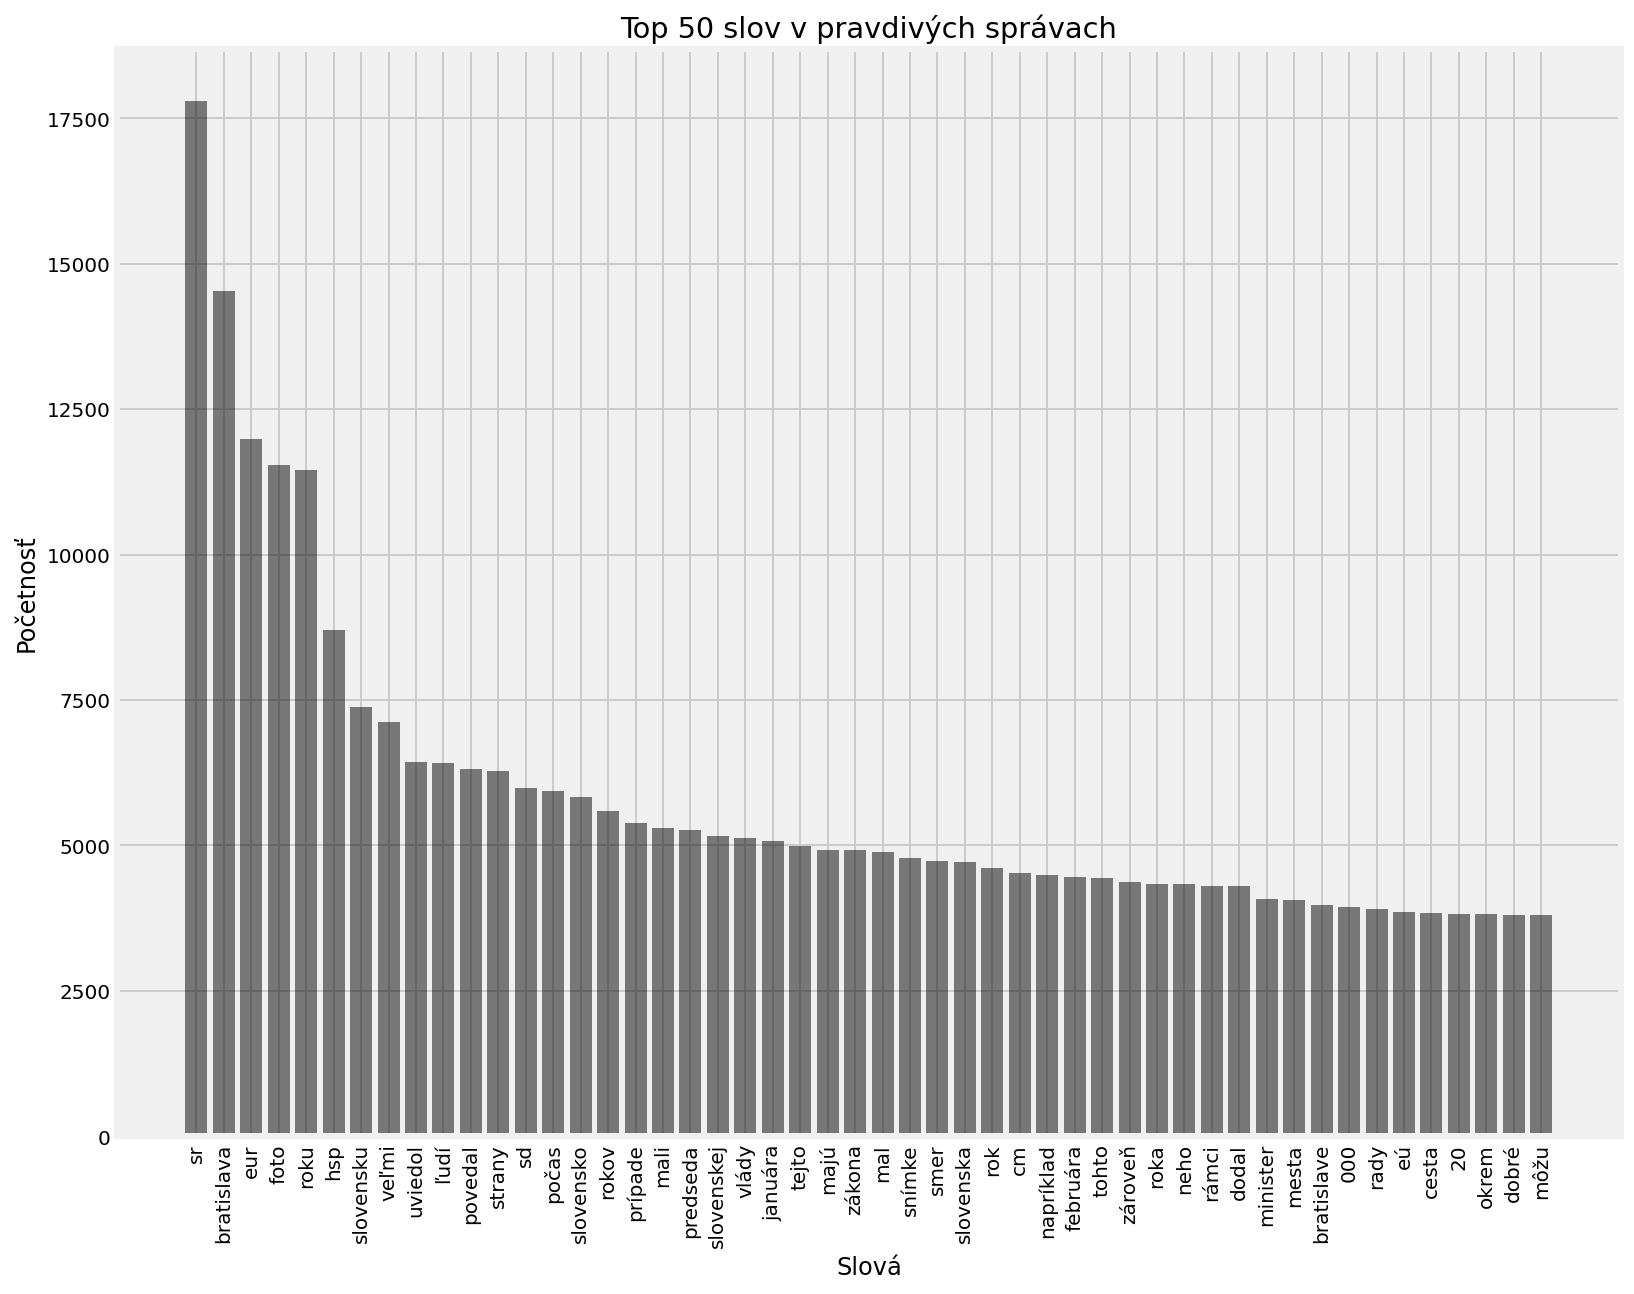

In [20]:
#graf TOP 50 slov vyskytujúcich sa v pravdivých správach
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5,color=["black"])
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Početnosť')
plt.xlabel('Slová')
plt.title('Top 50 slov v pravdivých správach')

Text(0.5, 1.0, 'Top 50 slov vo falošných správach')

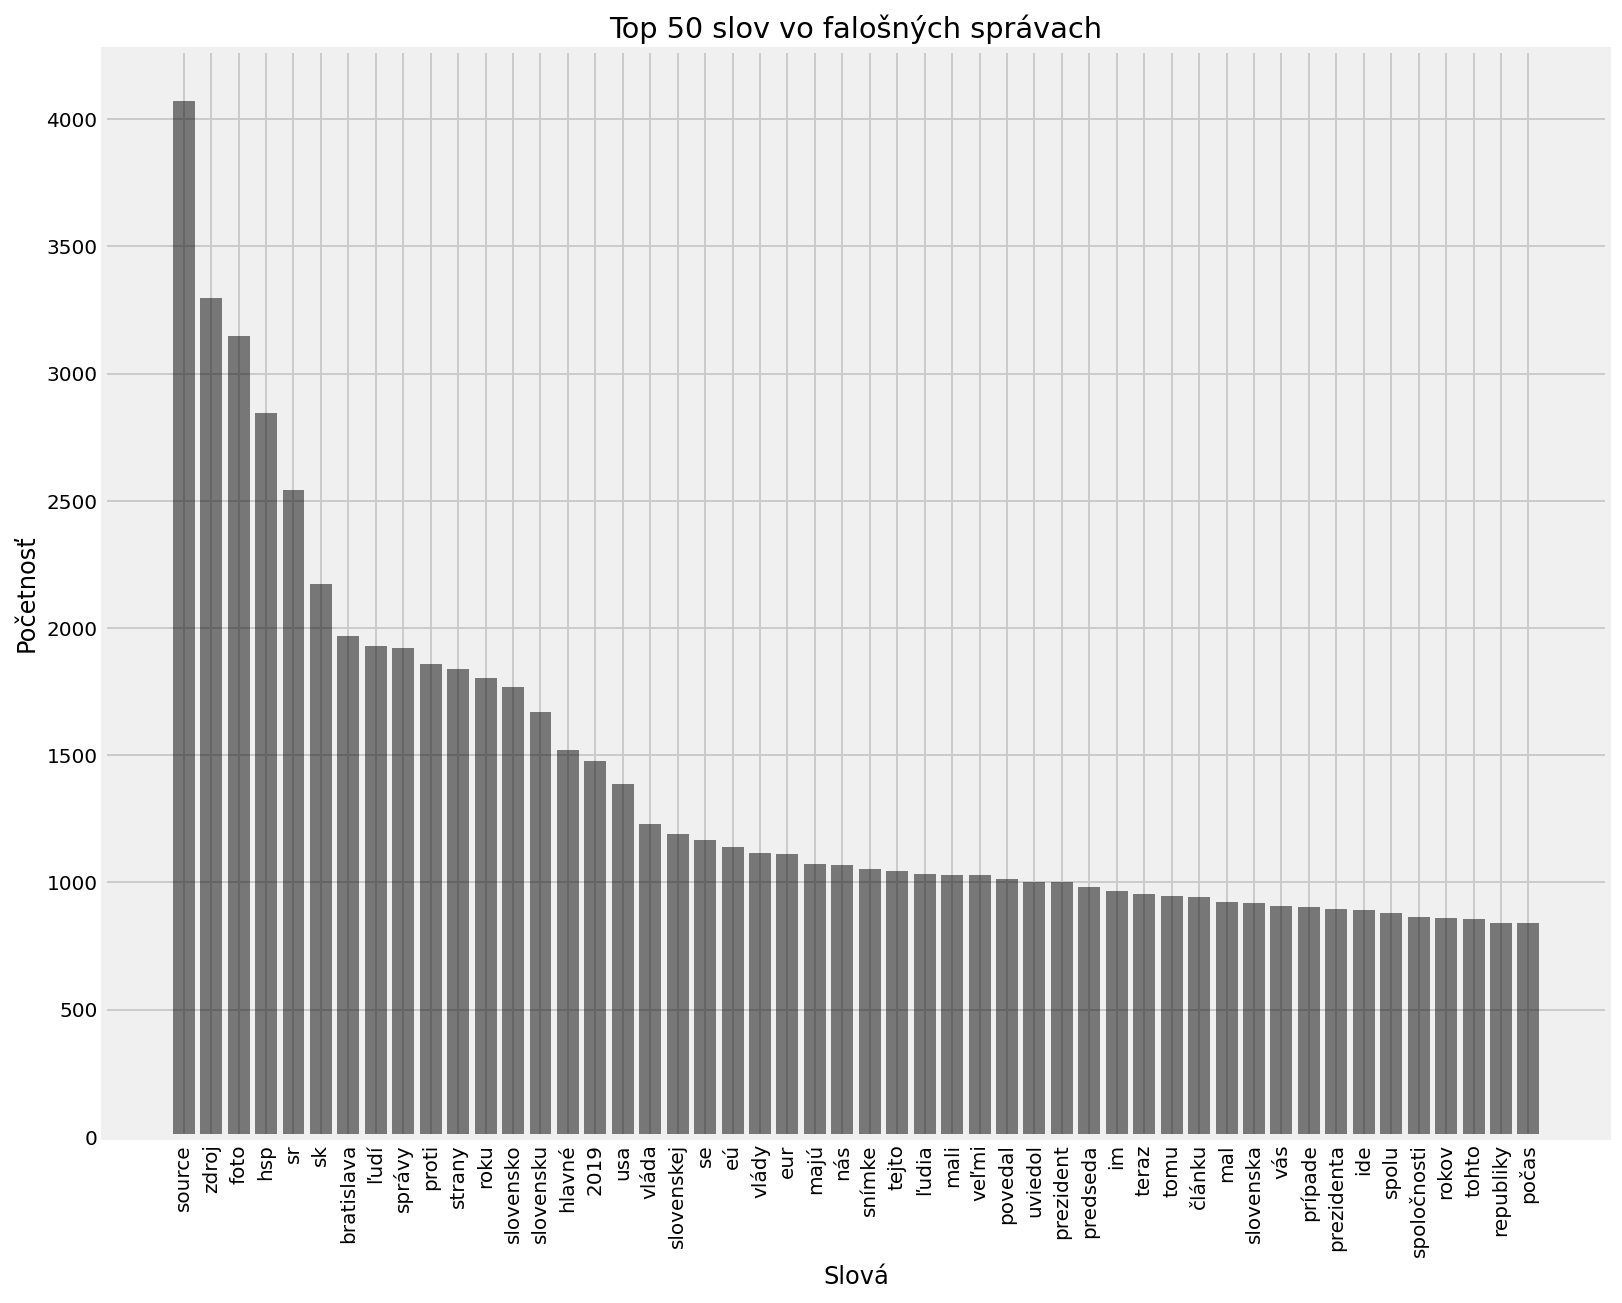

In [21]:
##graf TOP 50 slov vyskytujúcich sa vo falošných správach
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5,color=["black"])
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Početnosť')
plt.xlabel('Slová')
plt.title('Top 50 slov vo falošných správach')

#### V príprave dát do podoby vhodnej pre modelovanie musíme texty článkov vyčistiť a to vymazať interpunkčné znamienka, odkazy na internetové stránky, odkazy obrázkov, odkazy zdrojov, ponechať iba písmená abecedy a zjednotiť text na malé písmená.

In [22]:
#definovanie, čo sa má z textu odstrániť
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+' #odstránenie @
pat2 = r'https?://[^ ]+' #odstránenie odkazov https
combined_pat = r'|'.join((pat1, pat2)) #kombinovane odstránenie pat1 aj pat2
www_pat = r'www.[^ ]+' #odstránenie odkazov www
pat3=r'http?://[^ ]+' #odstránenie odkazov http
combined_pat2 = r'|'.join((www_pat, pat3)) 

pat4=r'img src=[^ ]+' #odstránenie odkazu na obrázok
pat5=r'\(SITA/[^)]*\)' #odstránenie konkrétneho odkazu začínajúceho sa zdrojom SITA
combined_pat3= r'|'.join((pat4, pat5)) 
pat6=r'\(HSP/[^)]*\)' #odstránenie konkrétneho odkazu začínajúceho sa zdrojom HSP
pat7=r'\(TASR/[^)]*\)' #odstránenie konkrétneho odkazu začínajúceho sa zdrojom TASR
combined_pat4= r'|'.join((pat6, pat7)) 

In [23]:
def cleaner(text):
    soup = BeautifulSoup(text, 'lxml') #dekódovanie html na všeobecný text
    souped = soup.get_text()
    try:
        bom_removed = souped.replace("ï¿½", "?") #ošetrenie chyby keď nedekóduje dobre
    except:
        bom_removed = souped
    stripped3 = re.sub(combined_pat, '', bom_removed)
    stripped2= re.sub(combined_pat2, '', stripped3)
    stripped1 = re.sub(combined_pat3, '', stripped2)
    stripped = re.sub(combined_pat4, '', stripped1)
    lower_case = stripped.lower()
    letters_only = re.sub("[^a-zA-Z\ÆÐƎƏƐƔĲŊŒẞÞǷȜæðǝəɛɣĳŋœĸſßþƿȝĄƁÇĐƊĘĦĮƘŁØƠŞȘŢȚŦŲƯY̨Ƴąɓçđɗęħįƙłøơşșţțŧųưy̨ƴÁÀÂÄǍĂĀÃÅǺĄÆǼǢƁĆĊĈČÇĎḌĐƊÐÉÈĖÊËĚĔĒĘẸƎƏƐĠĜǦĞĢƔáàâäǎăāãåǻąæǽǣɓćċĉčçďḍđɗðéèėêëěĕēęẹǝəɛġĝǧğģɣĤḤĦIÍÌİÎÏǏĬĪĨĮỊĲĴĶƘĹĻŁĽĿNŃN̈ŇÑŅŊÓÒÔÖǑŎŌÕŐỌØǾƠŒĥḥħıíìiîïǐĭīĩįịĳĵķƙĸĺļłľŀŉńn̈ňñņŋóòôöǒŏōõőọøǿơœŔŘŖŚŜŠŞȘṢẞŤŢṬŦÞÚÙÛÜǓŬŪŨŰŮŲỤƯẂẀŴẄǷÝỲŶŸȲỸƳŹŻŽẒŕřŗſśŝšşșṣßťţṭŧþúùûüǔŭūũűůųụưẃẁŵẅƿýỳŷÿȳỹƴźżžẓ]", " ", lower_case)
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [24]:
#čistenie textu na trénovacej a testovacej množine
testing_train = x_train.body[0:(len(x_train))]
test_result_train = []
for t in testing_train:
    test_result_train.append(cleaner(t))


testing_test = x_test.body[0:(len(x_test))]
test_result_test = []
for t in testing_test:
    test_result_test.append(cleaner(t))

C:\Users\Klaudia\Anaconda3\envs\tensorflow_env2\lib\site-packages\bs4\__init__.py:421: MarkupResemblesLocatorWarning: "http://dolezite.sk/Bola_nezna_revolucia_november_1989_podvodom.html
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
C:\Users\Klaudia\Anaconda3\envs\tensorflow_env2\lib\site-packages\bs4\__init__.py:421: MarkupResemblesLocatorWarning: "http://www.bnaibritheurope.org/bbe/content/view/640/lang,en/
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


In [25]:
#vytvorenie dataframe clean_df
clean_train = pd.DataFrame(test_result_train,columns=['body'])
clean_train['label'] = x_train.label #pridanie stĺpca label

clean_test = pd.DataFrame(test_result_test,columns=['body'])
clean_test['label'] = x_test.label 

In [26]:
#uloženie vyčisteného textu
clean_train.to_csv('clean_train_home_nebalans2.csv',encoding='utf-8')
csv_train = 'clean_train_home_nebalans2.csv'
df_train = pd.read_csv(csv_train,index_col=0)

clean_test.to_csv('clean_test_home.csv',encoding='utf-8')
csv_test = 'clean_test_home.csv'
df_test = pd.read_csv(csv_test,index_col=0)

#### Po vyčístení textu vymažeme potencionálne prázdne hodnoty, kde sa po definovaní kritérií vyčistenia mohlo stať, že bežný text v bunke nezostal. 

In [27]:
df_train.dropna(inplace=True) #vymazanie prázdnych hodnôt
df_train.reset_index(drop=True,inplace=True)

df_test.dropna(inplace=True) #vymazanie prázdnych hodnôt
df_test.reset_index(drop=True,inplace=True)

In [28]:
#ukážka vyčistenej dátovej množiny
df_train.head()

,body,label
0,hrachovo decembra všetky žiadosti posúdila cer...,0
1,source kočnera obvinili objednávky vraždy kuci...,1
2,prezident peru martín vizcarra jeho kolumbijsk...,1
3,nitra novembra tasr na univerzite konštantína ...,0
4,melbourne januára aktualizované slovenská juni...,1


In [29]:
df_train.label.value_counts()

0    15362
1     6263
Name: label, dtype: int64

In [30]:
df_test.label.value_counts()

0    6495
1    2776
Name: label, dtype: int64

#### Po vyčistení textu pokračujeme vytvorením tokenov z príslušných slov z textu a ich následným prevodom do vektorovej reprezentácie slov tzv. word embeddings. Na vytvorenie word embeddings použijeme nástroj Word2Vec, ktorý je implementovaný pomocou knižnice Gensim, kde výstupom bude množina vektorov. Pripravené vektory prevedieme na tokenizované a ich dĺžky zarovnáme na rovnaké doplnením nulových indexov.

In [31]:
#vytvorenie tokenom zo slov pre trénovaciu a testovaciu množinu
df_token_train = df_train['body'].values.tolist()

token_train=list()
for i in df_token_train:
    word_train=nltk.word_tokenize(i)
    word_train = [w for w in word_train if not w in stop_words]
    token_train.append(word_train)


df_token_test = df_test['body'].values.tolist()

token_test=list()
for i in df_token_test:
    word_test=nltk.word_tokenize(i)
    word_test = [w for w in word_test if not w in stop_words]
    token_test.append(word_test)

In [32]:
#word embeddings pomocou Word2Vec
model = Word2Vec(token_train, min_count = 1)
vocabulary = model.wv.vocab

name = 'w2v.txt'
model.wv.save_word2vec_format(name, binary = False)

embeddings_index = {}
f = open(os.path.join('','w2v.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word_train = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word_train] = coefs
f.close()

In [33]:
max_length = 1000

tokenizer = Tokenizer()
tokenizer.fit_on_texts(token_train)

seq_train = tokenizer.texts_to_sequences(token_train)
seq_test = tokenizer.texts_to_sequences(token_test)

word_index = tokenizer.word_index
print('Najdenych %s jedinecnych tokenov.' %len (word_index))

train_padding = pad_sequences(seq_train, max_length)
test_padding = pad_sequences(seq_test, max_length)

Najdenych 201770 jedinecnych tokenov.


In [34]:
EMBEDDING_DIM = 100
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word_train, ii in word_index.items():
    if ii > num_words:
        continue
    embedding_vector = embeddings_index.get(word_train)
    if embedding_vector is not None:
        embedding_matrix[ii] = embedding_vector

In [ ]:
y_train = df_train['label'].values
y_test = df_test['label'].values

#### Po pochopení dát a príprave dát prejdeme do fázy modelovania, kde vytvoríme dokopy 3 modely, ktoré vyhodnodnotíme pomocou kontingenčných tabuliek, úspešnosti, návratnosti, F1 skóre...

#### Prvý model je model neurónovej siete s konvolučnou vrstvou, s ReLu a Sigmoid aktivačnou funkciou a optimalizátorom Adam.

In [35]:
#architektúra CNN modelu
inputs = Input(shape=(max_length,))
x = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model_cnn = Model(inputs=inputs, outputs=output)
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model_cnn.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         20177100  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 999, 100)          20100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 20,223,313
Trainable params: 20,223,313
Non-trainable params: 0
_______________________________________________

In [ ]:
#uloženie modelu
saved_model = "model_cnn_home_bezstop.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
#trénovanie modelu
history = model_cnn.fit(train_padding, y_train, epochs=5, batch_size=32, validation_split=0.1, callbacks=[checkpoint])

In [ ]:
#načítanie modelu
model_cnn=load_model('model_cnn_home_bezstop.hdf5')

#predikcia na testovacích dátach pomocou natrénovaného modelu,
#vypísanie kontingenčnej tabuľky a metrík na vyhodnotenie ako úspešnosť, návrtanosť, F1 ...
y_cnn = model_cnn.predict(test_padding)
print('Roc auc score is {}'.format(roc_auc_score(y_test, y_cnn)))
y_int = np.zeros_like(y_cnn)
y_int[y_cnn > 0.5] = 1
print('Accuracy is {}'.format(accuracy_score(y_test,y_int)))

print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

|              | Precision | Recall | F1-score | Support |
|:------------:|:---------:|:------:|:--------:|:-------:|
|       0      |    0.94   |  0.99  |   0.96   |   6495  |
|       1      |    0.96   |  0.86  |   0.91   |   2776  |
|              |           |        |          |         |
|   Accuracy   |           |        |   0.95   |   9271  |
|   Macro avg  |    0.95   |  0.92  |   0.93   |   9271  |
| Weighted avg |    0.95   |  0.95  |   0.95   |   9271  |

Accuracy : 0.946931

ROC : 0.974959

| Actual/Predicted | Fake news | True news |
|------------------|-----------|-----------|
| Fake news        |   TP-2381  |   FN-395  |
| True news        |   FP-97  |  TN-6398  |

#### Druhý model je model neurónovej siete s rekurentnou LSTM vrstvou, s ReLu a Sigmoid aktivačnou funkciou a optimalizátorom Adam.

In [36]:
#architektúra LSTM modelu
inputs = Input(shape=(max_length,))
x = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model_lstm = Model(inputs=inputs, outputs=output)
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model_lstm.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         20177100  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 20,310,989
Trainable params: 20,310,989
Non-trainable params: 0
_______________________________________________

In [ ]:
#uloženie modelu
saved_model = "model_lstm_home_bezstop.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
#trénovanie modelu
history = model_lstm.fit(train_padding, y_train, epochs=5, batch_size=32, validation_split=0.1, callbacks=[checkpoint])

In [ ]:
#načítanie modelu
model_lstm=load_model('model_lstm_home_bezstop.hdf5')

#predikcia na testovacích dátach pomocou natrénovaného modelu,
#vypísanie kontingenčnej tabuľky a metrík na vyhodnotenie ako úspešnosť, návrtanosť, F1 ...
y_cnn = model_lstm.predict(test_padding)
print('Roc auc score is {}'.format(roc_auc_score(y_test, y_cnn)))
y_int = np.zeros_like(y_cnn)
y_int[y_cnn > 0.5] = 1
print('Accuracy is {}'.format(accuracy_score(y_test,y_int)))

print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

|              | Precision | Recall | F1-score | Support |
|:------------:|:---------:|:------:|:--------:|:-------:|
|       0      |    0.95   |  0.99  |   0.97   |   6495  |
|       1      |    0.97   |  0.88  |   0.92   |   2776  |
|              |           |        |          |         |
|   Accuracy   |           |        |   0.96   |   9271  |
|   Macro avg  |    0.96   |  0.93  |   0.95   |   9271  |
| Weighted avg |    0.96   |  0.96  |   0.96   |   9271  |

Accuracy : 0.955992

ROC : 0.975172

| Actual/Predicted | Fake news | True news |
|------------------|-----------|-----------|
| Fake news        |   TP-2442  |   FN-334  |
| True news        |   FP-74  |  TN-6421  |

#### Tretí model je model neurónovej siete s obojstrannou rekurentnou LSTM vrstvou a konvolučnou vrstvou, s ReLu a Sigmoid aktivačnou funkciou a optimalizátorom Adam.

In [37]:
#architektúra Bi-LSTM + CNN modelu
inputs = Input(shape=(max_length,))
x = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(32, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)
model_bilstm = Model(inputs=inputs, outputs=output)
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model_bilstm.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 100)         20177100  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1000, 100)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 128)         84480     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 998, 32)           12320     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112

In [ ]:
#uloženie modelu
saved_model = "model_bilstm_home_bezstop.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
#trénovanie modelu
history = model_bilstm.fit(train_padding, y_train, epochs=5, batch_size=32, validation_split=0.1, callbacks=[checkpoint])

In [ ]:
#načítanie modelu
model_bilstm=load_model('model_bilstm_home_bezstop.hdf5')

#predikcia na testovacích dátach pomocou natrénovaného modelu,
#vypísanie kontingenčnej tabuľky a metrík na vyhodnotenie ako úspešnosť, návrtanosť, F1 ...
y_cnn = model_bilstm.predict(test_padding)
print('Roc auc score is {}'.format(roc_auc_score(y_test, y_cnn)))
y_int = np.zeros_like(y_cnn)
y_int[y_cnn > 0.5] = 1
print('Accuracy is {}'.format(accuracy_score(y_test,y_int)))

print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

|              | Precision | Recall | F1-score | Support |
|:------------:|:---------:|:------:|:--------:|:-------:|
|       0      |    0.95   |  0.99  |   0.97   |   6495  |
|       1      |    0.97   |  0.87  |   0.92   |   2776  |
|              |           |        |          |         |
|   Accuracy   |           |        |   0.95   |   9271  |
|   Macro avg  |    0.96   |  0.93  |   0.94   |   9271  |
| Weighted avg |    0.95   |  0.95  |   0.95   |   9271  |

Accuracy : 0.953942

ROC : 0.979645

| Actual/Predicted | Fake news | True news |
|------------------|-----------|-----------|
| Fake news        |   TP-2431  |   FN-345  |
| True news        |   FP-65  |  TN-6418  |